## Text Mining of the Product Reviews

### Preparation

#### Read in packages

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import gender_guesser.detector as gender
import warnings
warnings.filterwarnings("ignore")
from dask import compute, delayed
import dask.multiprocessing
import multiprocessing
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import six
import statsmodels.api as sm
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
import yaml
import textstat

sns.set_style("white")
plt.style.use('seaborn-deep')

#pd.set_option('display.max_colwidth', 1)
# start=time.time()

#### Read in data

In [199]:
df = pd.read_csv("sample.csv")
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.drop(['asin'], axis = 1, inplace = True)
df.head(3)

,overall,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN
1,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN
2,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 11 columns):
overall           2567 non-null float64
vote              174 non-null object
verified          2567 non-null bool
reviewTime        2567 non-null object
reviewerID        2567 non-null object
style             2554 non-null object
reviewerName      2567 non-null object
reviewText        2567 non-null object
summary           2567 non-null object
unixReviewTime    2567 non-null int64
image             13 non-null object
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 203.2+ KB


#### Text cleaning & pre-processing

__Tokenization__: Split the text into sentences and the sentences into words. 

__Lowercase__ the words and __remove punctuation__.

Words that have fewer than 3 characters are removed.

All __stopwords__ are removed.

Words are __lemmatized__: words in third person are changed to first person and verbs in past and future tenses are changed into present.

Words are __stemmed__: words are reduced to their root form.

Reference: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [201]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem.porter import *
from gensim import corpora, models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

import spacy

import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lliu9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Functions to perform lemmatize and stem preprocessing steps

In [202]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [203]:
df.iloc[10]['reviewText']

"Absolutely love this keyboard.  I had an older one and the letters were worn off.  Didn't bother me, but my wife was very pleased when she saw that it had the letters still on the keys.  This keyboard feels great and is just designed so well."

In [204]:
doc_sample = df.iloc[19]['reviewText']
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
    
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['great', 'product', 'I', 'bought', 'these', 'as', 'a', 'present', 'and', 'they', 'love', 'it..', '', 'Thank', 'you..']


 tokenized and lemmatized document: 
['great', 'product', 'buy', 'present', 'love', 'thank']


##### Preprocess the data

In [205]:
processed_docs = df['reviewText'].map(preprocess)
processed_docs[:10]

0    [softwar, develop, liter, attach, keyboard, ty...
1    [natur, keyboard, year, work, look, home, keyb...
2    [microsoft, product, great, hardwar, poor, sof...
3                                               [love]
4               [version, keyboard, year, save, wrist]
5                                             [pefect]
6    [plug, work, like, champ, keyboard, take, get,...
7                         [instal, year, work, expect]
8    [like, like, split, half, board, like, challen...
9         [type, word, minut, unit, fifth, year, love]
Name: reviewText, dtype: object

##### Bag of words & Filter out infrequent tokens

In [206]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below = 20, no_above = 0.5, keep_n = 100000)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abl
1 actual
2 addit
3 adjust
4 appreci
5 attach
6 avail
7 base
8 begin
9 best
10 better


##### doc2bow
how many words and how many times those words appear in one document

In [207]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[100]

bow_doc = bow_corpus[100]
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0], 
                                               dictionary[bow_doc[i][0]], 
bow_doc[i][1]))

Word 41 ("good") appears 1 time.
Word 167 ("product") appears 1 time.
Word 204 ("great") appears 1 time.


##### TF-IDF (frequency-inverse document frequency)

how important a word is to a document in a collection or corpus

In [208]:
tfidf = models.TfidfModel(bow_corpus)
corpus = tfidf[bow_corpus]
for doc in corpus:
    pprint(doc)
    break

[(0, 0.05393611139497312),
 (1, 0.04749188386100658),
 (2, 0.1161012400496746),
 (3, 0.19760435362597248),
 (4, 0.13183336866359768),
 (5, 0.06456953191216998),
 (6, 0.06112932376946989),
 (7, 0.06456953191216998),
 (8, 0.06256213535682689),
 (9, 0.035752159660434095),
 (10, 0.035815457199263656),
 (11, 0.03413671082883778),
 (12, 0.04971758732312463),
 (13, 0.10939061359262094),
 (14, 0.09430149059889459),
 (15, 0.11146650154201666),
 (16, 0.05177074690699567),
 (17, 0.057503900019903055),
 (18, 0.06456953191216998),
 (19, 0.13377380233199793),
 (20, 0.15422545488550868),
 (21, 0.08789095625834734),
 (22, 0.13479309609830967),
 (23, 0.058331621538287554),
 (24, 0.11813275023000279),
 (25, 0.05777477479449792),
 (26, 0.06333323479975189),
 (27, 0.054149351044931085),
 (28, 0.06500530570680771),
 (29, 0.24184429621791756),
 (30, 0.06182866582907515),
 (31, 0.21099528176252355),
 (32, 0.054365658996412575),
 (33, 0.08558509394740033),
 (34, 0.05861797578217083),
 (35, 0.04089908636530390

### Topic model

##### LDA using Bag of Words

In [209]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 10, 
                                           random_state = 100,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',       
                                           per_word_topics = True)

In [210]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

Topic: 0 
Word: 0.019*"key" + 0.016*"type" + 0.016*"work" + 0.015*"microsoft" + 0.014*"space" + 0.014*"like" + 0.013*"comfort" + 0.012*"ergonom" + 0.012*"great" + 0.012*"natur"
Topic: 1 
Word: 0.110*"carpal" + 0.109*"center" + 0.107*"half" + 0.098*"unit" + 0.098*"word" + 0.060*"save" + 0.048*"busi" + 0.042*"syndrom" + 0.027*"arthriti" + 0.001*"certain"
Topic: 2 
Word: 0.126*"month" + 0.109*"board" + 0.068*"older" + 0.042*"regist" + 0.041*"hate" + 0.040*"hold" + 0.039*"realiz" + 0.038*"real" + 0.037*"begin" + 0.037*"harder"
Topic: 3 
Word: 0.069*"think" + 0.040*"excel" + 0.039*"posit" + 0.039*"price" + 0.034*"stick" + 0.034*"return" + 0.032*"requir" + 0.032*"switch" + 0.030*"small" + 0.029*"complaint"
Topic: 4 
Word: 0.129*"happen" + 0.103*"certain" + 0.096*"glad" + 0.093*"track" + 0.062*"prevent" + 0.044*"tend" + 0.001*"impress" + 0.001*"mistak" + 0.001*"rat" + 0.001*"half"
Topic: 5 
Word: 0.067*"wear" + 0.054*"thumb" + 0.050*"regular" + 0.048*"tunnel" + 0.042*"improv" + 0.029*"couldn"

##### Model Perplexity and Coherence Score

 judge how good a given topic model is

In [211]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = processed_docs, dictionary = dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.4499672109203345

Coherence Score:  0.3658336676823061


#### Optimal number of topics for LDA 

In [213]:
def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [214]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus, texts=processed_docs, 
                                                        start=2, limit = 30, step = 1)

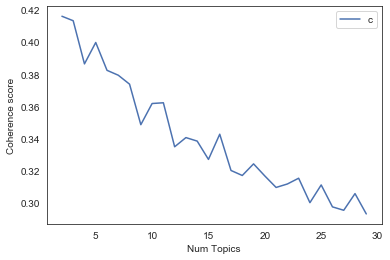

In [215]:
limit = 30; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

##### Topic proportions as features

In [216]:
lda_model_5 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 5, 
                                           random_state = 100,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',       
                                           per_word_topics = True)

In [217]:
props = []
for ind in range(len(corpus)):
    props.append([i[1].round(5) for i in lda_model_5.get_document_topics(corpus[ind])])

In [218]:
df["Topic1"] = [i[0] for i in props]
df["Topic2"] = [i[1] for i in props]
df["Topic3"] = [i[2] for i in props]
df["Topic4"] = [i[3] for i in props]
df["Topic5"] = [i[4] for i in props]

#### Visualization

In [269]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_5, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.264268 -0.148400       1        1  48.470100
2     -0.310390 -0.110646       2        1  39.896767
3      0.017882  0.301330       3        1   4.736831
1      0.015825  0.003061       4        1   3.851159
4      0.012415 -0.045346       5        1   3.045132, topic_info=    Category       Freq     Term      Total  loglift  logprob
331  Default  28.000000     mous  28.000000  30.0000  30.0000
150  Default  24.000000    excel  24.000000  29.0000  29.0000
261  Default  18.000000   instal  18.000000  28.0000  28.0000
399  Default  16.000000   switch  16.000000  27.0000  27.0000
293  Default  17.000000   tunnel  17.000000  26.0000  26.0000
..       ...        ...      ...        ...      ...      ...
462   Topic5   0.124735   combin   4.652711  -0.1274  -7.6878
404   Topic5   0.125663     hunt   5.433403  -0.2751  -7.6804
563   Topic5   0.126558     wast   6.949539  -0.5141  -7.6733
186   Topic5   0.127697  browser  11.264904  -0.9882  -7.6644
223   Topic5   0.127162     mice  10.748535  -0.9454  -7.6686

[207 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
385       3  0.972844  accustom
391       3  0.983401      aren
324       3  0.907503       arm
289       4  0.765388  arthriti
416       5  0.944318    awesom
...     ...       ...       ...
137       2  0.635204      work
138       1  0.984041     wrist
139       1  0.157451      year
139       2  0.839737      year
140       2  0.993275      zoom

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

### Features engineering

Som epossible features from literature: `length`, `reviewer identity`, `foreign brand`, `product type`, `extremity (low/high ratings)`,`writing style`, `timeliness`, `spelling errors`, `readability`, `subjectivity`, `rating scores`, ``

#### Convert vote variable to float type

In [219]:
def cleanvote(df):
    """
    Outputs the votes as numerical values 
    """
    try:
        return float(df['vote'])
    except ValueError:
        return float(df['vote'].replace(',', ''))
    
df['vote'] = df.apply(cleanvote, axis=1)

#### Get the number of associated images

In [220]:
def imagenum(df):
    """
    Outputs the number of images from the `image` column
    """
    if type(df['image']) == float:
        return 0
    else:
        return len(df['image'])

df['imagenum'] = df.apply(imagenum, axis=1)

#### Get the indicator of being verified or not

In [221]:
def verified(df):
    """
    Outputs the indicator (1/0) from the `verified` column
    """
    if df['verified'] == True:
        return 1
    else:
        return 0
    
df['verified'] = df.apply(verified, axis=1)

#### Get the indicator of using a real name

One tried approach: named entities extraction

Pbm: cannot tell the real or seemingly-real names

https://towardsdatascience.com/custom-named-entity-recognition-using-spacy-7140ebbb3718

https://spacy.io/usage/linguistic-features#named-entities

Approach: return true if the `revierName` has verfied first names by gender guesser (not unknown in the name database), (middle name), and last name 

https://pypi.org/project/gender-guesser/

In [222]:
def nameverified(df):
    """
    Output the indicator (1/0) from the `reviewerName` column 
    """
    try:
        parts = df['reviewerName'].split(' ')
        if len(parts) > 2:
            if gender.Detector().get_gender(parts[0]) != 'unknown': 
                return 1
        else:
            return 0
    except AttributeError:
        return 0

df['nameverified'] = df.apply(nameverified, axis=1)
df['nameverified'] = df['nameverified'].fillna(0)

#### Sentiment

In [223]:
def sentiment(df):
    """
    Outputs the sentiment score for each review
    """
    return analyser.polarity_scores(df['reviewText'])['compound']

df['Sentiment'] = df.apply(sentiment, axis=1)

In [224]:
# Sentiment scores are positively correlated with the overall rating, but the correlation is not strong
round(np.corrcoef(df['overall'],  df["Sentiment"])[0,1],3)

0.376

In [225]:
# correlation within the reviews with positive votes
dfnotnull = df[df['vote'].isna()==0]
np.corrcoef(dfnotnull['vote'],  dfnotnull["Sentiment"])[0,1]

0.033122594194551894

#### Length

https://pypi.org/project/textstat/

In [226]:
def length(df):
    """
    Output the length for each review
    """
    return textstat.lexicon_count(df['reviewText'], removepunct = True)

df['Length'] = df.apply(length, axis=1)

#### Sentence Count

In [227]:
def sentence_count(df):
    """
    Output the number of sentences for each review
    """
    return textstat.sentence_count(df['reviewText'])

df['Sentences'] = df.apply(sentence_count, axis=1)

#### Flesch reading ease score

In [228]:
def flesch(df):
    """
    Output the Flesch reading ease score for each review
    """
    return textstat.flesch_reading_ease(df['reviewText'])

df['Flesch'] = df.apply(flesch, axis=1)

#### Days since the first review

In [229]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df['Days'] = df['unixReviewTime'] - df['unixReviewTime'].min()
df['Days'] = [i.days for i in df['Days']]

#### Before/After verified purchase policy

In [230]:
def verified_option(df):
    """
    Output whether the review was written after the introduction of verified purchase label policy
    """
    if df['unixReviewTime'].date()> datetime(2016, 11, 1).date():
        return 1
    else:
        return 0

df['verified_option'] = df.apply(verified_option, axis=1)
round(100*sum(df['verified_option'])/len(df))

13

#### Styles (Different models)

In [231]:
df['style'].value_counts()

{'Style:': ' Retail'}      1930
{'Style:': ' Business'}     624
Name: style, dtype: int64

In [232]:
# This function is useful when there are multiple categories in 'style'
def style(df):
    """
    Output the style of the product
    """
    try:
        if 'Size:' in df['style']:
            return yaml.load(df['style'])['Style:']
    except:
        return 0

#df['style'] = df.apply(style, axis=1)


In [233]:
df['Retail'] = np.where(df['style'] == "{'Style:': ' Retail'}", 1, 0)
sum(df['Retail'])

1930

### Exploratory Data Analysis 

In [236]:
df.drop(['style', 'reviewerID', 'reviewerName', 
         'image', 'reviewTime',], axis=1, inplace=True)

In [273]:
df.head()

,overall,vote,verified,reviewText,summary,unixReviewTime,Topic1,Topic2,Topic3,Topic4,...,imagenum,nameverified,Sentiment,Length,Sentences,Flesch,Days,verified_option,Retail,vote_fillna
0,5.0,1113.0,1,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,2005-10-18,0.51249,0.03440,0.38076,0.04386,...,0,0.0,0.9981,780,1,-703.31,13,0,1,1113.0
1,5.0,16.0,1,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,2005-10-12,0.50907,0.03559,0.37827,0.04773,...,0,0.0,0.8232,267,1,-182.62,7,0,1,16.0
2,4.0,11.0,1,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",2005-10-05,0.47337,0.03552,0.41958,0.04301,...,0,0.0,0.9947,917,15,34.84,0,0,1,11.0
3,5.0,NaN,1,Love it.,Five Stars,2018-05-15,0.49030,0.03804,0.39451,0.04705,...,0,0.0,0.6369,2,1,120.21,4605,1,0,0.0
4,5.0,NaN,1,I've had various versions of this keyboard for...,Five Stars,2018-05-12,0.48442,0.03767,0.39339,0.04660,...,0,0.0,0.4753,16,1,80.62,4602,1,0,0.0


In [276]:
df.columns

Index(['overall', 'vote', 'verified', 'reviewText', 'summary',
       'unixReviewTime', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5',
       'imagenum', 'nameverified', 'Sentiment', 'Length', 'Sentences',
       'Flesch', 'Days', 'verified_option', 'Retail', 'vote_fillna'],
      dtype='object')

In [279]:
diff = df.groupby(['verified']).mean().round(2)
diff[['overall', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5',
       'imagenum', 'nameverified', 'Sentiment', 'Length', 'Sentences',
       'Flesch', 'Days', 'verified_option', 'Retail']]

,overall,Topic1,Topic2,Topic3,Topic4,Topic5,imagenum,nameverified,Sentiment,Length,Sentences,Flesch,Days,verified_option,Retail
verified,,,,,,,,,,,,,,,
0,3.59,0.49,0.04,0.4,0.05,0.03,1.26,0.08,0.42,140.30,4.76,35.79,2485.26,0.09,0.83
1,4.30,0.48,0.04,0.4,0.05,0.03,0.43,0.07,0.46,72.01,2.85,57.27,3234.58,0.13,0.74


In [266]:
df['unixReviewTime'].min()

Timestamp('2005-10-05 00:00:00')

In [267]:
df['unixReviewTime'].max()

Timestamp('2018-05-19 00:00:00')

#### Summary statistics

In [239]:
df['vote_fillna'] = df['vote'] .fillna(0)

In [240]:
df.describe().round(2)

,overall,vote,verified,Topic1,Topic2,Topic3,Topic4,Topic5,imagenum,nameverified,Sentiment,Length,Sentences,Flesch,Days,verified_option,Retail,vote_fillna
count,2567.00,174.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2484.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00
mean,4.21,16.41,0.86,0.48,0.04,0.40,0.05,0.03,0.55,0.08,0.45,81.37,3.12,54.32,3131.83,0.13,0.75,1.11
std,1.21,90.98,0.34,0.01,0.00,0.01,0.00,0.00,9.56,0.27,0.54,103.03,3.74,65.76,965.37,0.33,0.43,23.98
min,1.00,2.00,0.00,0.46,0.03,0.38,0.04,0.03,0.00,0.00,-0.99,0.00,1.00,-1108.30,0.00,0.00,0.00,0.00
25%,4.00,2.00,1.00,0.48,0.04,0.39,0.05,0.03,0.00,0.00,0.14,20.00,1.00,46.44,2740.00,0.00,1.00,0.00
50%,5.00,3.00,1.00,0.48,0.04,0.40,0.05,0.03,0.00,0.00,0.64,49.00,2.00,71.48,3351.00,0.00,1.00,0.00
75%,5.00,5.00,1.00,0.49,0.04,0.40,0.05,0.03,0.00,0.00,0.88,102.00,4.00,83.66,3789.50,0.00,1.00,0.00
max,5.00,1113.00,1.00,0.51,0.06,0.42,0.07,0.04,370.00,1.00,1.00,1179.00,41.00,206.84,4609.00,1.00,1.00,1113.00


In [241]:
# % of reviews don't have any votes
df['vote'].isna().sum()/df.shape[0]

0.9322165952473704

In [242]:
# % of reviews don't have images
len(df[df['imagenum']==0])/df.shape[0]

0.9949357226334242

In [243]:
df['verified'].value_counts()

1    2215
0     352
Name: verified, dtype: int64

In [244]:
# Verified reviews have higher average scores
df.groupby(['verified']).mean()['overall']

verified
0    3.593750
1    4.303837
Name: overall, dtype: float64

In [248]:
# Verified reviews have higher votes
df.groupby(['verified']).mean()['vote']

verified
0     9.294118
1    19.357724
Name: vote, dtype: float64

In [247]:
df.groupby(['verified']).count()['vote']

verified
0     51
1    123
Name: vote, dtype: int64

In [263]:
df.head(100)

,overall,vote,verified,reviewText,summary,unixReviewTime,Topic1,Topic2,Topic3,Topic4,...,imagenum,nameverified,Sentiment,Length,Sentences,Flesch,Days,verified_option,Retail,vote_fillna
0,5.0,1113.0,1,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,2005-10-18,0.51249,0.03440,0.38076,0.04386,...,0,0.0,0.9981,780,1,-703.31,13,0,1,1113.0
1,5.0,16.0,1,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,2005-10-12,0.50907,0.03559,0.37827,0.04773,...,0,0.0,0.8232,267,1,-182.62,7,0,1,16.0
2,4.0,11.0,1,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",2005-10-05,0.47337,0.03552,0.41958,0.04301,...,0,0.0,0.9947,917,15,34.84,0,0,1,11.0
3,5.0,NaN,1,Love it.,Five Stars,2018-05-15,0.49030,0.03804,0.39451,0.04705,...,0,0.0,0.6369,2,1,120.21,4605,1,0,0.0
4,5.0,NaN,1,I've had various versions of this keyboard for...,Five Stars,2018-05-12,0.48442,0.03767,0.39339,0.04660,...,0,0.0,0.4753,16,1,80.62,4602,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.0,3.0,1,"I was diagnosed with carpal tunnel, very mild,...",Returns feeling to carpal-tunnel fingers withi...,2017-11-30,0.46401,0.03961,0.42288,0.04482,...,0,0.0,-0.0120,138,1,-51.68,4439,1,0,3.0
96,1.0,NaN,1,I bought one of these keyboards six or seven y...,You get what you pay for.,2017-11-26,0.49490,0.03660,0.38919,0.05034,...,0,0.0,0.7979,87,6,65.22,4435,1,0,0.0
97,5.0,NaN,1,"Great product, easy on the wrists.","Great product, easy on the wrists",2017-11-23,0.48806,0.03763,0.39798,0.04655,...,0,0.0,0.7906,6,1,90.77,4432,1,0,0.0
98,5.0,NaN,1,very nice,Five Stars,2017-11-22,0.49030,0.03804,0.39451,0.04705,...,0,0.0,0.4754,2,1,120.21,4431,1,0,0.0


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 21 columns):
overall            2567 non-null float64
vote               174 non-null float64
verified           2567 non-null int64
reviewText         2567 non-null object
summary            2567 non-null object
unixReviewTime     2567 non-null datetime64[ns]
Topic1             2567 non-null float64
Topic2             2567 non-null float64
Topic3             2567 non-null float64
Topic4             2567 non-null float64
Topic5             2567 non-null float64
imagenum           2567 non-null int64
nameverified       2567 non-null float64
Sentiment          2567 non-null float64
Length             2567 non-null int64
Sentences          2567 non-null int64
Flesch             2567 non-null float64
Days               2567 non-null int64
verified_option    2567 non-null int64
Retail             2567 non-null int32
vote_fillna        2567 non-null float64
dtypes: datetime64[ns](1), float64(11), in

### Export data

In [260]:
df.to_csv('keyboard_data.csv', index = False)